# Detecting the most popular tourist attractions in Valencia using unsupervised learning techniques
## DSCAN algorithm for discovering the most popular photographed locations in Valencia (Spain).
### Author: Amanda Iglesias Moreno

<br />
<figure>
  <img src="images/portada.jpg" alt="my alt text" width="500" height="500"/>
  <figcaption class="figure-caption text-center">Historic center of Valencia - Photo by Jonny James on Unsplash</figcaption>
</figure>

**Valencia** is one of the most cosmopolitan and vibrant cities in Spain. Located on the **Mediterranean coast**, Valencia is **the third-largest city and metropolitan region in Spain**. The city has been the home of many different cultures over its more than 2000 years of history. Romans, Visigoths, and Muslims occupied Valencia, leaving as inheritance a rich collection of art and a distinct architectonic patrimony. At present, Valencia is a popular spot for tourists, receiving roughly 2 million visitors every year. 

In this article, we will analyze **the most relevant spots in Valencia** using the geoinformation of the photographs provided by **Flickl**. To do so, we will use the algorithm **DBSCAN**, an **unsupervised learning technique** that provides clusters of data based on density.

## Flickr API
**Flickr** is one of the most popular photo-sharing sites. To use the **Flickr API**, you need both a **Flickr API key** and a **Flicker user ID**. Once you have a user ID and an API key, you can search for images using the **flickrapi library**. 
The first part of the project consists of importing all the libraries needed along with the creation of a **FlickrAPI object**.

In [52]:
import flickrapi
import time
import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import preprocessing
import seaborn as sns
import folium
from folium.plugins import HeatMap

# your API key and secret
api_key = u'3a500e823f55613be4f5acee369d4041'
api_secret = u'b7ac06684cafe24f'

# creation of a FlickrAPI object
flickr = flickrapi.FlickrAPI(api_key, api_secret)

## Obtaining the photos using the flickr.photos.search function

The next step consists of obtaining the photos of interest using the **Flickr API**. The `flickr.photos.search` function returns a list of photos of Flickr's repository based on given parameters. In order to simplify the analysis, we will only download from the repository the **photos taken in Valencia in 2019**. We can specify the **date of interest (2019)** using the arguments (1) `min_upload_date`, and (2) `max_upload_date`. Additionally, we are going to download only **public photos** (`media='photos'` and `privacy_filter=1`) available on the platform, excluding videos and private photos. Finally, we provide the **boundary box of Valencia** to guarantee that only photos of this specific region are retrieved.

In [7]:
# create a default dictionary to store information about the photos
# the keys are the attributes of interest and the values the data
photo_information = defaultdict(list)

# we loop through the different pages that contain photos of Valencia taken in 2019
i = 1
while True:     
    result = flickr.photos.search(
                    per_page=400, #number of data per page
                    has_geo=1, #Photo that has geo location
                    min_taken_date='2019-1-01', # minimum date - 1 Jan 2019
                    max_taken_date='2019-12-31', # maximum data - 31 Dec 2019
                    bbox='-0.4558,39.4384,-0.2814,39.5064', # boundary box of valencia
                    media='photos', #collecting only photos (videos excluded)
                    sort='date-taken-desc', 
                    privacy_filter=1,#collecting only public photos (private photos excluded)
                    safe_search=1, #photos without violence
                    extras='geo,url_n,date_taken,views,license',
                    page=i)
    
    # pause the execution of the program 2 seconds
    time.sleep(2)
    
    # obtain the number of pages (first iteration)
    # this information is contained in the photos tag and it will allows us to determine when to break the loop
    if i == 1:
        pages = int(result[0].attrib['pages'])
        print('Number of pages: {}'.format(pages))
    
    # print the number of the page - iteration of the while loop
    print(i, end=' ')  
    
    # loop through all the photos available in the page
    # store (1) the id, (2) the latitude, (3) the longitude, and (4) the URL of the photo in the dictionary  
    for element in result[0].findall('photo'):
        photo_information['id'].append(element.attrib['id'])
        photo_information['latitude'].append(element.attrib['latitude'])
        photo_information['longitude'].append(element.attrib['longitude'])
        photo_information['url_n'].append(element.attrib['url_n'])

    # if the page correspond to the last page we break the loop  
    if i == pages:
        break
    else:
        i = i + 1  

Number of pages: 72
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 

## Defining the Bounding Box of the area
As shown in the code above, we need to provide the **boundary box of Valencia** to the `flickr.photos.search` function (parameter `bbox`) to retrieve only the photographs taken in this region. To obtain the coordinates of the area, we can use the **OpenStreetMap** database. After manually drawing the region of interest on the map, the **boundary box coordinates** (bottom-left longitude, bottom-left latitude, top-right longitude, top-right latitude) will appear in the text box located in the upper left corner, as you can see below. Then, we need to provide those coordinates to the `bbox` parameter as a string, where the values are separated by commas.

<br />
<figure>
  <img src="images/openstreet.png" alt="oppenstreetmap"/>
  <figcaption class="figure-caption text-center">Obtaining the Boundary box of Valencia with OpenStreetMap</figcaption>
</figure>

# Converting the output of the search function (XML element) into a Pandas DataFrame

The `flickr.photos.search` function sends back a parsed **XML element** when you call the function. This element contains multiple **details about the photographs** that match the search criteria. The `rsp` tag indicates in the attribute `stat` whether the call was executed successfully or not. The `photos` tag provides a summary of the search results. In this case, 10732 pictures match the search criteria organized in 250 pages. Within the `photos` tag, there is a list of `photo` tags, each of them containing the information of a particular photo. In this case, **the attributes of interest are only four: (1) the id, (2) the latitude, (3) the longitude, and (4) the URL of the photo**; however, as you can see below, the number of attributes provided by the search function to describe a photo is much larger.

In [106]:
# visualize the tree structure of the XML element obtained after calling the search function
ET.dump(result[0][0])

<photo accuracy="15" context="0" datetaken="2019-12-30 20:12:27" datetakengranularity="0" datetakenunknown="0" farm="66" geo_is_contact="0" geo_is_family="0" geo_is_friend="0" geo_is_public="1" height_n="180" id="49332010233" isfamily="0" isfriend="0" ispublic="1" latitude="39.456690" license="0" longitude="-0.352592" owner="135414206@N06" place_id="" secret="aefcefc2b7" server="65535" title="Happy New Year" url_n="https://live.staticflickr.com/65535/49332010233_aefcefc2b7_n.jpg" views="3362" width_n="320" woeid="6362115" />
	


As shown in the code above, we store the information of interest in a dictionary called `photo_information`, where the keys represent the attributes of interest and the values are lists containing the data, where each index stores the details of one photo. 

Finally, we can easily convert the dictionary into a pandas data frame using the `pandas.DataFrame` constructor, as shown below.


In [107]:
# convert the dictionary into a Pandas dataframe
df_photos = pd.DataFrame(photo_information) 

# visualize the first 5 rows of the dataframe
df_photos.head()

,id,latitude,longitude,url_n
0,49332010233,39.456690,-0.352592,https://live.staticflickr.com/65535/4933201023...
1,49733562156,39.457288,-0.353162,https://live.staticflickr.com/65535/4973356215...
2,49378157241,39.456100,-0.354062,https://live.staticflickr.com/65535/4937815724...
3,49383309452,39.457288,-0.353162,https://live.staticflickr.com/65535/4938330945...
4,49343808407,39.457288,-0.353162,https://live.staticflickr.com/65535/4934380840...


## Data Cleaning
After retrieving the information of interest, the data frame obtained contains only four columns: (1) `id`, (2) `latitude`, (3) `longitude`, and (4) `url_n`. It is a really simple data set; however, we can not use it directly to cluster the data. We need first to clean it out.

The data set does not contain missing values; however, the data types of **the columns latitude and longitude are wrongly detected**. We need to convert these columns into floats to be able to use them later in the **DBSCAN algorithm**.

In [108]:
# get a summary of the data frame
df_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17997 entries, 0 to 17996
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         17997 non-null  object
 1   latitude   17997 non-null  object
 2   longitude  17997 non-null  object
 3   url_n      17997 non-null  object
dtypes: object(4)
memory usage: 562.5+ KB


In [109]:
# convert the columns latitude and longitud into floats
df_photos['latitude'] = df_photos['latitude'].astype(float)
df_photos['longitude'] = df_photos['longitude'].astype(float)

After correcting wrong data types, we analyze whether or not the data frame includes **duplicated photos**. Every photo store in Flickr has its own unique id. Therefore, it is not possible to have two different pictures with the same id. As you can observe below, **most of the photos are duplicated**, so we need to eliminate them from the data frame.

In [110]:
# number of duplicated photos in the data set
df_photos.duplicated().sum()

14535

In [111]:
# eliminate duplicated photos from the data set
df_photos = df_photos.drop_duplicates()

# size of the data set after removing duplicated photos
df_photos.shape

(3462, 4)

Once the duplicated entries are removed, we eliminate the `id` and `url_n` columns from the data set, since they are no longer needed.

In [112]:
# remove id and url_n columns from the data set
df_photos.drop(['id', 'url_n'], axis=1, inplace=True)

In [113]:
# save the data set as a csv file
df_photos.to_csv('valencia_photos.csv')

Now, we can use the data to obtain the clusters that indicate the most popular spots of the city.

## DBSCAN algorithm
### Theory

The **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) method is a **density-based clustering algorithm** used to separate high-density from low-density regions.

This algorithm is based on **two hyperparameters**:
* **The radius (eps)**: The maximum distance between two samples to be considered as neighbors.
* **The minimum number of points (MinPts)**: The number of samples in the neighborhood to consider an observation a core point.

Based on these hyperparameters, the **DBSCAN algorithm** classifies every observation in the data set as a **core, border, or outlier point**, according to the following rules:
* **Core point**: A data point that has at least *MinPts* observations within its radius *eps*.
* **Border point**: A data point that has within its radius *eps* less than *MinPts* points; however, the point is within the radius *eps* of a core point. 
* **Outlier point**: A data point that is neither a core point nor a border point.


Then, the points are assigned to clusters based on their types. Each cluster contains at least one core point and all border points that are reachable from it.

<br />
<figure>
  <img src="images/type_points.png" alt="my alt text" width="500" height="500"/>
  <figcaption class="figure-caption text-center">Core, border, and outlier points - Image created by the author</figcaption>
</figure>

### Advantages and disadvantages
The DBSCAN algorithm offers multiple advantages with respect to other clustering algorithms. The major strength of the DBSCAN algorithm is that it can **find out clusters of any shape**. The clusters do not have to have a blob shape. Additionally, **it is not necessary to fix the number of clusters** before executing the algorithm, as we have to do with the K-means method. Furthermore, **DBSCAN is capable of detecting noise** in the data set, in contrast to partitional-based algorithms such as K-means which assign all points to a cluster. With DBSCAN, the points located in the regions of low density are not assigned to any cluster.

However, the DBSCAN method has also some disadvantages. **The main challenge of the algorithm is to find the right combination of the two hyperparameters (eps and MinPts)**. The choice of these hyperparameters is arbitrary and highly affects the results obtained with the algorithm. A common practice is to test different sets of hyperparameters and choose the one that produces acceptable results taking into consideration the number of clusters and the outliers generated.

<br />
<figure>
  <img src="images/dbscan_advantages.png" alt="my alt text" width="500" height="500"/>
    <figcaption class="figure-caption text-center">Advantages and disadvantages of the DBSCAN algorithm - Image created by the author</figcaption>
</figure>

## Visualization of the observations with a scatter plot
The following plot shows the location of the photographs taken in Valencia in 2019 (available on the Flickr platform). The **x-axis represents the longitude** where the photo was taken, and the **y-axis represents the latitude**. As you can see, there are locations where clearly more photos were taken (high dense areas). The next step consists of using the **DBSCAN algorithm** to recognize these locations.

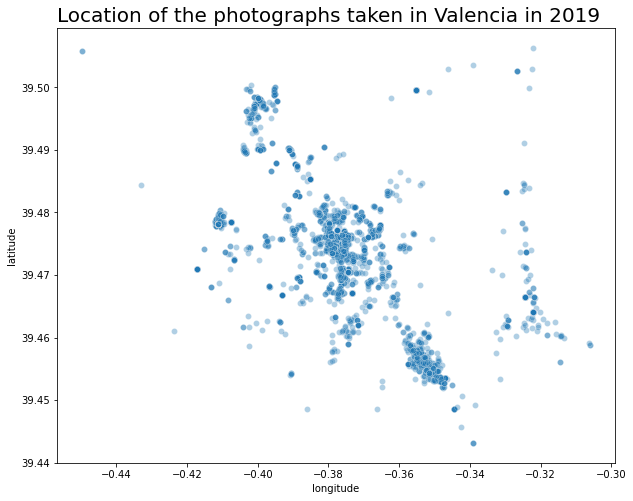

In [114]:
# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Location of the photographs taken in Valencia in 2019', loc='left', fontsize=20)
sns.scatterplot(x=df_photos.longitude, y=df_photos.latitude, alpha=.35);

## Implementation of the DBSCAN algorithm with Scikit-Learn
To implement the DBSCAN algorithm, we need first to instantiate a `DBSCAN` model, which can be imported from `sklearn.cluster`. As you can see below, the hyperparameters chosen for this particular dataset are: (1) `eps=` , and (2) `min_samples=`. These parameters were defined by trial and error. Notice that before applying the DBSCAN algorithm, we have normalized the data points with the `MinMaxScaler` class, so that all attributes (latitude and longitude) have the same range `[0, 1]`.

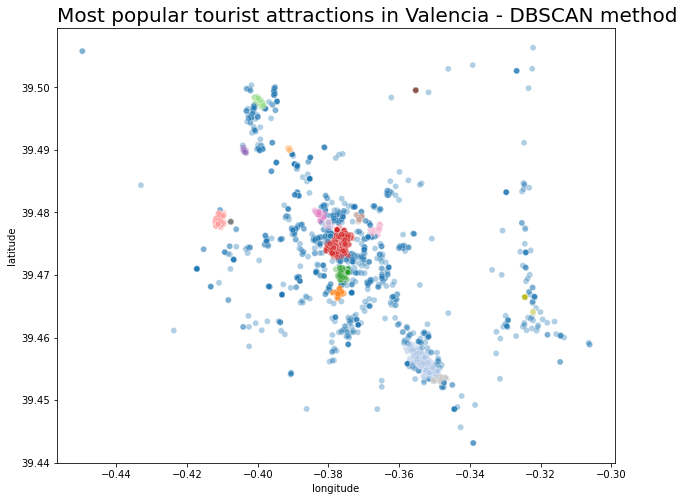

In [115]:
# normalization of the data using the min max method
scaler = preprocessing.MinMaxScaler()

# normalization - fit and transform the data
df_photos_scaled = scaler.fit_transform(df_photos)

# apply the dbscan algorithm to the dataset
tourist_points = cluster.DBSCAN(eps=0.010, min_samples=35).fit(df_photos_scaled)

# labels of the clusters
labels_tourist_points = tourist_points.labels_

# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Most popular tourist attractions in Valencia - DBSCAN method', loc='left', fontsize=20)
sns.scatterplot(x=df_photos.longitude, y=df_photos.latitude, alpha=.35,
                hue=labels_tourist_points, palette="tab20", legend=None);

We can determine the number of clusters by looking at the unique values of the labels. As you can see, some observations have **an index equal to -1**, meaning those observations are detected as **outliers** by the algorithm.

In [116]:
np.unique(labels_tourist_points)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16], dtype=int64)

Lastly, we visualize the clusters **excluding the noise** (observations associated with a label equal to -1). Additionally, we have plotted the labels associated with each group in the cluster center.

In [117]:
# exclude the observations with a label equal to -1. 
df_photos_filtered = df_photos[tourist_points.labels_ != -1]

# exclude the labels equal to -1
labels_tourist_points_filtered = labels_tourist_points[labels_tourist_points != -1]

In [118]:
# calculate the center of each cluster
mean_location_clusters = []
for group in np.unique(labels_tourist_points_filtered):
    mean_location_clusters.append(list(df_photos_filtered[labels_tourist_points_filtered==group].mean()))

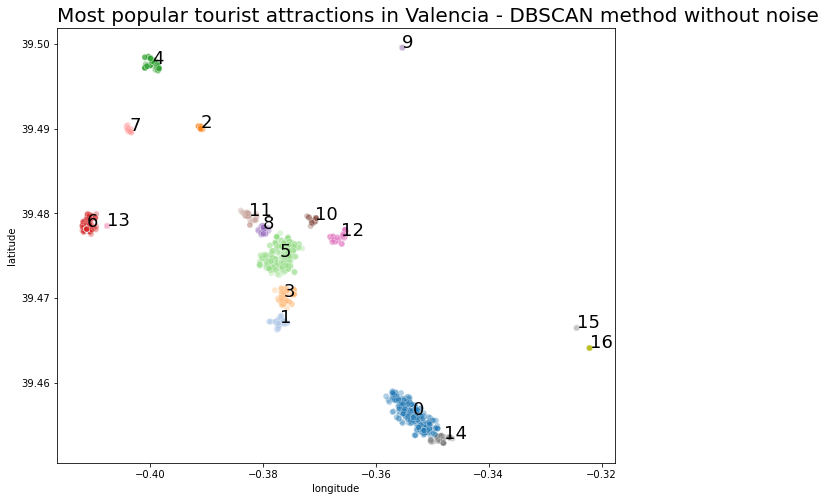

In [119]:
# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Most popular tourist attractions in Valencia - DBSCAN method without noise', loc='left', fontsize=20)
sns.scatterplot(x=df_photos_filtered.longitude, y=df_photos_filtered.latitude, alpha=.35,
                hue=labels_tourist_points_filtered, palette="tab20", legend=None);

# visualize the label associated to each cluster
for index, location in enumerate(mean_location_clusters):
    plt.text(location[1], location[0], str(index), fontsize=18);

## Visualizing the centers on the clusters on an interactive map
The next step is to **visualize the cluster centers on top of the map of Valencia**. This approach will allow us to easily **make associations between the centers of the groups and the locations in the city**.

First, we construct a **Folium map** with a location and a zoom level. This will produce an empty map of the given location (in this case Valencia). Then, we render markers at the location of the cluster centers with the `Marker` function.

In [120]:
# creation of an empty map of Valencia
valencia_map = folium.Map(location=[39.46975, -0.37739], zoom_start=13)

# plot the locations of the center of the clusters
for index, location in enumerate(mean_location_clusters):
    folium.map.Marker(location=[location[0], location[1]],
                      icon=folium.plugins.BeautifyIcon(border_color='blue',
                                                       text_color='blue',
                                                       number=index,
                                                       icon_shape='marker')).add_to(valencia_map)

# show the map
valencia_map

## Associations of the clusters - Most important spots in Valencia
We can recognize the following points of interest by visualizing the center of the groups on top of the map of Valencia:
* **Cluster 0**: The city of the arts and sciences
* **Cluster 1**: The North Railway Station
* **Cluster 2**: Burjassot Avenue
* **Cluster 3**: Town Hall Square
* **Cluster 4**: Benicalap Park 
* **Cluster 5**: The historic center of the city
* **Cluster 6**: Bioparc (The Zoo)
* **Cluster 7**: Parroquia San Josemaría Escrivá
* **Cluster 8**: El Carmen Neighborhood
* **Cluster 9**: Sport Center (Alboraya)
* **Cluster 10**: Museum of Fine Arts of València
* **Cluster 11**: Institut Valencià d'Art Modern
* **Cluster 12**: Jardines de Monforte
* **Cluster 13**: Parc de Capçalera
* **Cluster 14**: L'Oceanogràfic
* **Cluster 15**: Resort Las Arenas
* **Cluster 16**: Malvarrosa Beach

## My favorite places
### Cluster  5 - The historic center of the city
The **historic center of Valencia** is without any doubt the most charming part of the city. Nowadays, the historic center is the **heart of leisure and trade** in modern Valencia **packed with shops, restaurants, and bars**. The Central Market, the Cathedral, the Silk Exchange, and El Carmen Neighborhood are among the most important insights of Valencia Old Town.

<br />
<figure>
  <img src="images/historic_center.jpg" alt="my alt text" width="500" height="500"/>
  <figcaption class="figure-caption text-center">Historic center of Valencia - Photo by AI Elmes on Unsplash</figcaption>
</figure>

### Clusters 0 and 14  - The city of the arts and sciences
The **city of the arts and sciences** is a cultural and scientific complex designed by the Valencian architect **Santiago Calatrava**. It is **situated at the end of the Turia riverbed** and it is one of the most visited spots in Valencia. Officially **inagurated in April 1998**, the **city of the arts and sciences** is made of 7 buildings: **L'Hemisfèric** (1998), **El Museu de les Ciències Príncipe Felipe** (2000), **L'Umbracle** (2001), **L'Oceanogràfic** (2003), **El Palau de les Arts Reina Sofia** (2005), and **L'Àgora** (2009). The complex offers a wide range of cultural activities and events during the whole year.

<br />
<figure>
  <img src="images/city.jpg" alt="my alt text" width="500" height="500"/>
  <figcaption class="figure-caption text-center">City of the arts and sciences - Photo by Peter Lawrence on Unsplash</figcaption>
</figure>

## Alternative visualization - Heat map of the photographs 
The last step of the analysis consists of **visualizing the location of the photographs (latitude and longitude) using a heat map**. Heat maps use color to display how a quantity changes across a region. In this case, we use Folium again to create a heat map that overlays on top of the map of Valencia.

In [121]:
# create an empty map of Valencia
valencia_heat_map = folium.Map(location=[39.46975, -0.37739], zoom_start=13)

# creation of a Heat map
HeatMap(df_photos, radius=20, blur=20).add_to(valencia_heat_map)

# show the map
valencia_heat_map